**Chapter 14 – Deep Computer Vision Using Convolutional Neural Networks**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/jdecorte/machinelearning/blob/main/140_deep_computer_vision_with_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Setup

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. CNNs can be very slow without a GPU.


A couple utility functions to plot grayscale and RGB images:

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# What is a Convolution?

- The studie of the human visual cortex inspired researchers to an neural network architecture which gradually evolved into what we now call convolutional neural networks. An important milestone was a 1998 - - This architecture has some building blocks that you already know, such as fully connected layers and sigmoid activation functions, but it also introduces two new
building blocks: 
    - convolutional layers
    - pooling layers

Why not simply use a deep neural network with fully connected layers for image recognition tasks? 
- Unfortunately, although this works fine for small images (e.g., MNIST), it breaks down for larger images because of the huge number of parameters it requires. 
- For example, a 100 × 100–pixel image has 10,000 pixels, and if the first layer has just 1,000 neurons (which already severely restricts the amount of information transmitted to the next layer), this means a total of 10 million connections. And that’s just the first layer. 
- CNNs solve this problem using partially connected layers and weight sharing.

## Convolutional Layers
- Neurons in the first convolutional layer are not connected to every single pixel in the input image (like they were in the layers discussed in previous chapters), but only to pixels in their receptive fields:
![](img/cnn.png)

- All the multilayer neural networks we’ve looked at so far had layers composed of a long line of neurons, and we had to flatten input images to 1D before feeding them to the neural network. In a CNN each layer is represented in 2D, which makes it easier to match neurons with their corresponding inputs.
- In a CNN, each neuron in the second layer is connected only to neurons located within a small rectangle in the first layer.
- This architecture allows the network to **concentrate on small low-level features in the first hidden layer**, **then** assemble them into **larger higher-level features in the next hidden layer**, and so on.
- A neuron located in row $i$, column $j$ of a given layer is connected to the outputs of the neurons in the previous layer located in rows $i$ to $i + f_h – 1$, columns $j$ to $j + f_w – 1$, where $f_h$ and $f_w$ are the height and width of the receptive field (see figure below). 
- In order for a layer to have the same height and width as the previous layer, it is common to add zeros around the inputs, as shown in the diagram. This is called zero padding.

![](img/cnn_connections.png)

It is also possible to connect a large input layer to a much smaller layer by spacing out the receptive fields: 

![](img/cnn_stride.png)

- This dramatically reduces the model’s computational complexity. 
- The shift from one receptive field to the next is called the _stride_. 
- In the diagram, a 5 × 7 input layer (plus zero padding) is connected to a 3 × 4 layer, using 3 × 3 receptive fields and a stride of 2 (in this example the stride is the same
in both directions, but it does not have to be so). 
- A neuron located in row $i$, column $j$ in the upper layer is connected to the outputs of the neurons in the previous layer located in rows $i × s_w$ to $i × s_w + f – 1$, columns $j × s_h$ to $j × s_h + f – 1$, where $s_w$ and $s_h$ are the vertical and horizontal strides.

## Filters

- A neuron’s weights can be represented as a small image the size of the receptive field. 
- For example, the figure below shows two possible sets of weights, called filters (or convolution kernels). 
- The first one is represented as a black square with a vertical white line in the middle (it is a 7 × 7 matrix full of 0s except for the central column, which is full of 1s)
  - neurons using these weights will ignore everything in their receptive field except for the central vertical line (since all inputs will get multiplied by 0, except for the ones located in the central vertical line). 
- The second filter is a black square with a horizontal white line in the middle. 
  - neurons using these weights will ignore everything in their receptive field except for the central horizontal line.

![](img/cnn_filters.png)

- Now if all neurons in a layer use the same vertical line filter (and the same bias term), and you feed the network the input image shown in the figuure (the bottom image), the layer will output the top-left image. 
  - notice that the vertical white lines get enhanced while the rest gets blurred. 
- Similarly, the upper-right image is what you get if all neurons use the same horizontal line filter
  - notice that the horizontal white lines get enhanced while the rest is blurred out. 
- Thus, a layer full of neurons using the same filter outputs a feature map, which highlights the areas in an image that activate the filter the most. 
- Of course, **you do not have to define the filters manually**: instead, **during training the convolutional layer will automatically learn the most useful filters** for its task, and the layers above will learn to combine them into more complex patterns. 

## Stacking Multiple Feature maps
- Up to now, for simplicity, Ie have represented the output of each convolutional layer as a 2D layer
- In reality a convolutional layer has multiple filters (you decide how many) and outputs one feature map per filter, so it is more accurately represented in 3D:

![](img/cnn_stacking.png)

- Specifically, a neuron located in row $i$, column $j$ of the feature map $k$ in a given convolutional layer $l$ is connected to the outputs of the neurons in the previous layer $l – 1$, located in rows $i × s_h$ to $i × s_h + f – 1$ and columns $j × s_w$ to $j × s_w + f – 1$, across all feature maps (in layer $l – 1$).
- Note that all neurons located in the same row $i$ and column $j$ but in different feature maps are connected to the outputs of the exact same neurons in the previous layer.










## TensorFlow Implementation

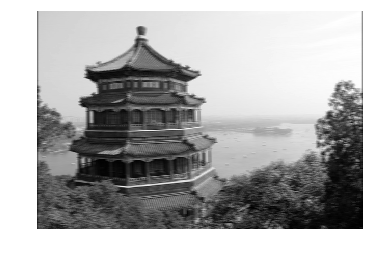

In [3]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

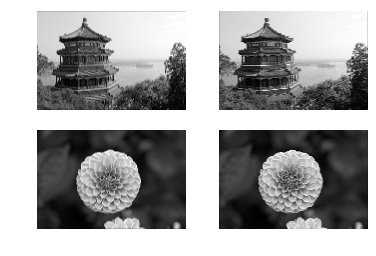

In [4]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [5]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


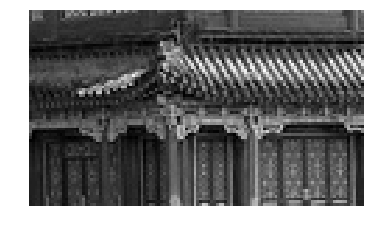

Saving figure china_vertical


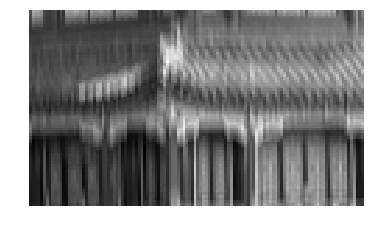

Saving figure china_horizontal


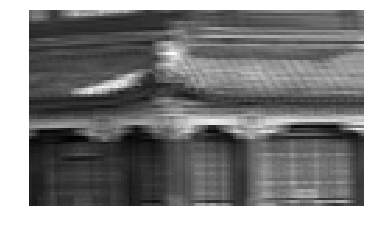

In [6]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

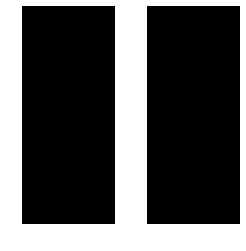

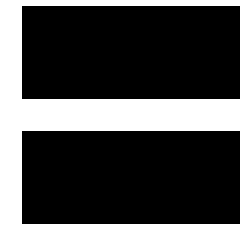

In [7]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## Convolutional Layer

Let's create a 2D convolutional layer, using `keras.layers.Conv2D()`:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

Let's call this layer, passing it the two test images:

In [9]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

The output is a 4D tensor. The dimensions are: batch size, height, width, channels. The first dimension (batch size) is 2 since there are 2 input images. The next two dimensions are the height and width of the output feature maps: since `padding="SAME"` and `strides=1`, the output feature maps have the same height and width as the input images (in this case, 427×640). Lastly, this convolutional layer has 2 filters, so the last dimension is 2: there are 2 output feature maps per input image.

Since the filters are initialized randomly, they'll initially detect random patterns. Let's take a look at the 2 output features maps for each image:

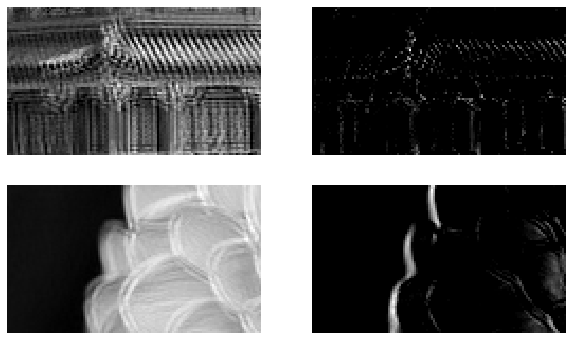

In [10]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

Although the filters were initialized randomly, the second filter happens to act like an edge detector. Randomly initialized filters often act this way, which is quite fortunate since detecting edges is quite useful in image processing.

If we want, we can set the filters to be the ones we manually defined earlier, and set the biases to zeros (in real life we will almost never need to set filters or biases manually, as the convolutional layer will just learn the appropriate filters and biases during training):

In [11]:
conv.set_weights([filters, np.zeros(2)])

Now let's call this layer again on the same two images, and let's check that the output feature maps do highlight vertical lines and horizontal lines, respectively (as earlier):

In [12]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

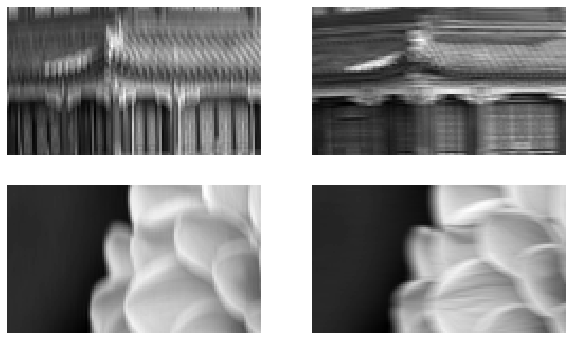

In [13]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

## VALID vs SAME padding

In [14]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [15]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [16]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

Using `"SAME"` padding is equivalent to padding manually using `manual_same_padding()` then using `"VALID"` padding (confusingly, `"VALID"` padding means no padding at all):

In [17]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

# Pooling layer

## Max pooling

In [18]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [19]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


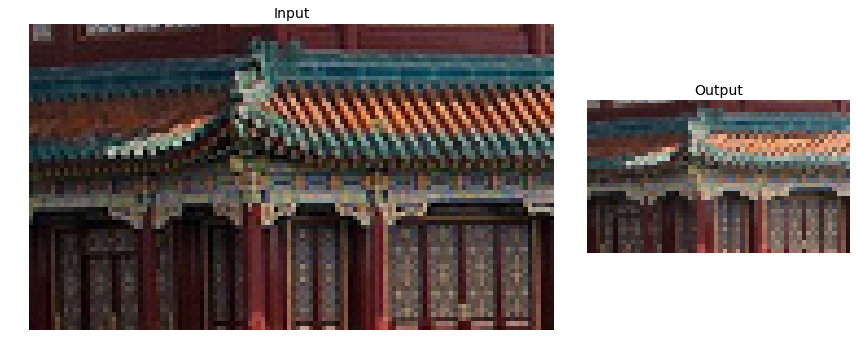

In [20]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

## Depth-wise pooling

In [21]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [22]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

Or just use a `Lambda` layer:

In [23]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

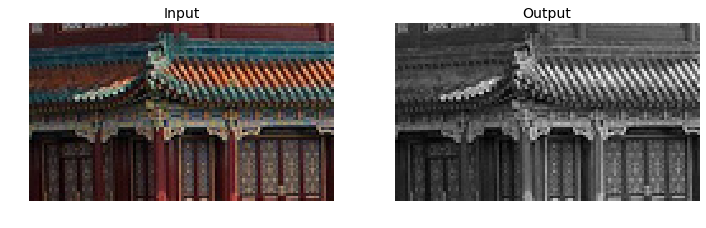

In [24]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

## Average pooling

In [25]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [26]:
output_avg = avg_pool(cropped_images)

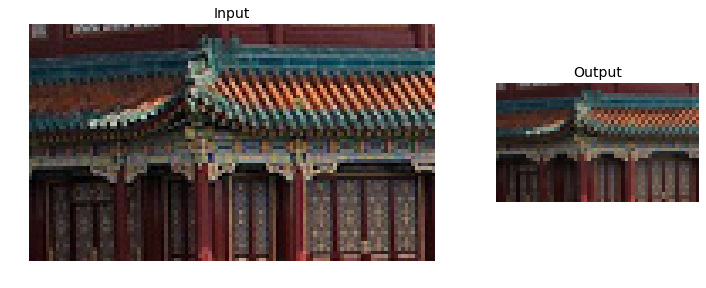

In [27]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Global Average Pooling

In [28]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: id=151, shape=(2, 3), dtype=float64, numpy=
array([[0.27887768, 0.2250719 , 0.20967274],
       [0.51288515, 0.45951634, 0.33423483]])>

In [29]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: id=155, shape=(2, 3), dtype=float64, numpy=
array([[0.27887768, 0.2250719 , 0.20967274],
       [0.51288515, 0.45951634, 0.33423483]])>

# Tackling Fashion MNIST With a CNN

In [30]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [31]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [32]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 51s 923us/sample - loss: 0.7183 - accuracy: 0.7529 - val_loss: 0.4029 - val_accuracy: 0.8510
Epoch 2/10
55000/55000 [==============================] - 47s 863us/sample - loss: 0.4185 - accuracy: 0.8592 - val_loss: 0.3285 - val_accuracy: 0.8854
Epoch 3/10
55000/55000 [==============================] - 46s 836us/sample - loss: 0.3691 - accuracy: 0.8765 - val_loss: 0.2905 - val_accuracy: 0.8936
Epoch 4/10
55000/55000 [==============================] - 46s 832us/sample - loss: 0.3324 - accuracy: 0.8879 - val_loss: 0.2794 - val_accuracy: 0.8970
Epoch 5/10
55000/55000 [==============================] - 48s 880us/sample - loss: 0.3100 - accuracy: 0.8960 - val_loss: 0.2872 - val_accuracy: 0.8942
Epoch 6/10
55000/55000 [==============================] - 51s 921us/sample - loss: 0.2930 - accuracy: 0.9008 - val_loss: 0.2863 - val_accuracy: 0.8980
Epoch 7/10
55000/55000 [=====================

See appendix A.

The following model uses 2 convolutional layers, followed by 1 pooling layer, then dropout 25%, then a dense layer, another dropout layer but with 50% dropout, and finally the output layer. It reaches about 99.2% accuracy on the test set. This places this model roughly in the top 20% in the [MNIST Kaggle competition](https://www.kaggle.com/c/digit-recognizer/) (if we ignore the models with an accuracy greater than 99.79% which were most likely trained on the test set, as explained by Chris Deotte in [this post](https://www.kaggle.com/c/digit-recognizer/discussion/61480)). Can you do better? To reach 99.5 to 99.7% accuracy on the test set, you need to add image augmentation, batch norm, use a learning schedule such as 1-cycle, and possibly create an ensemble.

In [71]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [72]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 102s 2ms/sample - loss: 0.1887 - accuracy: 0.9417 - val_loss: 0.0502 - val_accuracy: 0.9864
Epoch 2/10
55000/55000 [==============================] - 99s 2ms/sample - loss: 0.0815 - accuracy: 0.9754 - val_loss: 0.0414 - val_accuracy: 0.9904
Epoch 3/10
55000/55000 [==============================] - 103s 2ms/sample - loss: 0.0612 - accuracy: 0.9810 - val_loss: 0.0367 - val_accuracy: 0.9896
Epoch 4/10
55000/55000 [==============================] - 100s 2ms/sample - loss: 0.0496 - accuracy: 0.9846 - val_loss: 0.0376 - val_accuracy: 0.9900
Epoch 5/10
55000/55000 [==============================] - 104s 2ms/sample - loss: 0.0405 - accuracy: 0.9876 - val_loss: 0.0363 - val_accuracy: 0.9916
Epoch 6/10
55000/55000 [==============================] - 99s 2ms/sample - loss: 0.0368 - accuracy: 0.9882 - val_loss: 0.0352 - val_accuracy: 0.9924
Epoch 7/10
55000/55000 [=============================

[0.027682604857745575, 0.992]